# Перенос стиля 

## Обзор

Статья Леона А. Гэтиса https://arxiv.org/abs/1508.06576

Neural style transfer (Перенос нейронного стиля) - это метод оптимизации, используемый для получения трех изображений, изображения **содержимого**, изображения **референса стиля** (например, работы известного художника) и **входного изображения**, которое хотите стилизовать - и смешать их вместе так, чтобы входное изображение было преобразовано, чтобы выглядеть как изображение содержимого, но «нарисовано» в стиле изображения стиля.


Например, возьмем изображение этой черепахи и «Великой волны у Канагавы» Кацусики Хокусая:

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" alt="Drawing" style="width: 200px;"/>
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/The_Great_Wave_off_Kanagawa.jpg?raw=1" alt="Drawing" style="width: 200px;"/>

[Image of Green Sea Turtle](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)
-By P.Lindgren [CC BY-SA 3.0  (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Commons

Как бы это выглядело, если бы Хокусай решил нарисовать эту черепаху исключительно в этом стиле? Что-то вроде этого?

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png?raw=1" alt="Drawing" style="width: 500px;"/>

Это магия или просто глубокое обучение? К счастью, это не связано с каким-либо колдовством: перенос стиля - это забавный и интересный метод, демонстрирующий возможности и внутренние представления нейронных сетей.

Принцип переноса нейронного стиля состоит в том, чтобы определить две функции расстояния, одна из которых описывает, насколько различается содержимое двух изображений, $L_{content}$, а другая описывает разницу между двумя изображениями с точки зрения их стиля, $L_{style}$. Затем, имея три изображения, желаемое изображение стиля, желаемое изображение содержимого и входное изображение (инициализированное изображением содержимого), мы пытаемся преобразовать входное изображение, чтобы минимизировать расстояние содержимого с изображением содержимого и расстояние его стиля с помощью стиль изображения.
Таким образом, мы возьмем базовое входное изображение, изображение контента, которое мы хотим сопоставить, и изображение стиля, которое мы хотим сопоставить. Мы преобразуем базовое входное изображение, минимизируя расстояния (потери) между содержимым и стилями с помощью обратного распространения, создавая изображение, которое соответствует содержимому изображения содержимого и стилю изображения стиля.

### Конкретные концепции, которые будут рассмотрены:
В процессе мы будем накапливать практический опыт и развивать интуицию вокруг следующих концепций.

* **Eager Execution** - используйте среду обязательного программирования TensorFlow, которая момментально оценивает операции
   *[Подробнее о Eager Execution] (https://www.tensorflow.org/programmers_guide/eager)
   *[В действии] (https://www.tensorflow.org/get_started/eager)
* **Используя [Функциональный API] (https://keras.io/getting-started/functional-api-guide/) для определения модели** - мы создадим подмножество нашей модели, которое даст нам доступ к необходимой промежуточной активации с использованием функционального API
* **Использование карт признаков предварительно обученной модели** - Узнайте, как использовать предварительно обученные модели и их карты признаков.
* **Создание пользовательских циклов обучения** - мы рассмотрим, как настроить оптимизатор, чтобы минимизировать заданные потери в соответствии с параметрами входа.

### Шаги для переноса стиля:

1. Визуализация данных.
2. Базовая предварительная обработка/ подготовка наших данных.
3. Настройка функции потерь.
4. Создание модели.
5. Оптимизация функции потерь

Доп. информация:
* Прочтите [статью Гэтиса] (https://arxiv.org/abs/1508.06576) - мы объясним по ходу дела, но документ предоставит более полное понимание задачи.
* [Понять, как уменьшить потери с помощью градиентного спуска] (https://developers.google.com/machine-learning/crash-course/reeding-loss/gradient-descent)

** Расчетное время **: 30 мин.

## Установка

### Загрузка изображений

### Импорт и настройка модулей

In [1]:
# Для визуализации и графиков
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10) # определяем размер отображаемой картинки
mpl.rcParams['axes.grid'] = False # убираем сетку (это изменение навтройки для matplotlib,  делается 1 раз)

# поддержка больших многомерных массивов и матриц
import numpy as np
# для обработки графики в Python
from PIL import Image
# для работы со временем
import time
# инструменты для адаптации или расширения функций и других вызываемых объектов
import functools

In [2]:
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

Мы начнем с включения [eager execution](https://www.tensorflow.org/guide/eager). Eager execution позволяет нам проработать эту технику самым ясным и понятным образом. 

In [3]:
# tf.enable_eager_execution()
# print("Eager execution: {}".format(tf.executing_eagerly()))

In [4]:
# Пути для входной картинки и картинки со стилем 
content_path = './images/Green_Sea_Turtle_grazing_seagrass.jpg' # путь к входному изображению
style_path = './images/The_Great_Wave_off_Kanagawa.jpg' # путь к стилевому изображению

## Визуализация входной картинки

In [5]:
def load_img(path_to_img):
    '''
    Загрузка и предобработка изображения
    
    Parameters
    ----------
    path_to_img: str 
        Путь к изображению
        
    Returns
    -------
    img: numpy.array, shape = [1, height, width, channels]
        массив, соответствующий изображению
    '''
    max_dim = 512 # максимальная размерность изображения
    img = Image.open(path_to_img) # открываем изобр. библиотекой PIL
    long = max(img.size) # возвращает ммаксимальный элемент (длину или ширину)
    scale = max_dim/long # я так понимаю, что это типа нормализации, тут делим заданную макс размерномть на полученный максимальный эелемент
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS) # изменение изображения, где применяется наша нормализация. 3 параметр количество каналов, остается неизменным
    
    img = kp_image.img_to_array(img) # Преобразует экземпляр изображения PIL в массив Numpy.

    # Нужно расширить массив изображений, чтобы он имел заданную размерность для объявления батча. Добаляем новую размерность по оси 0 (строка)
    img = np.expand_dims(img, axis=0)
    return img # возвращает массив, соответствующий изображению

In [6]:
def imshow(img, title=None):
    '''
    Вывод изображения на экран
    
    Parameters
    ----------
    img: numpy.array, shape = [1, height, width, channels]
        Массив, соответсвующий изображению
    title: str
        Заголовок изображения. По умолчанию: None
    '''
    
    # Удаляем размерности (батча)
    out = np.squeeze(img, axis=0) # удаляет оси с одним элементом (длинной 1), но не сами элементы массива. т.е. тут удаляем размерность, заданную для батча
    # Нормализация для вывода 
    out = out.astype('uint8') # тип uint8 - целые числа в диапазоне от 0 по 255 (числа размером 1 байт)
    plt.imshow(out) # строим график
    if title is not None: # Если есть заголовок, выводим его
        plt.title(title)
    plt.imshow(out)

Это входной контент и изображения стиля. Мы надеемся «создать» изображение с нашим содержимым, но свыбранным стилем.

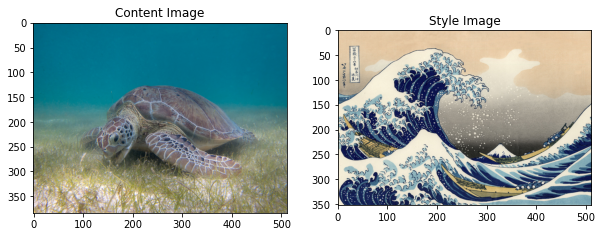

In [7]:
plt.figure(figsize=(10,10)) # размер отображаемого изображения

content = load_img(content_path).astype('uint8') # загружаем подготовленной функцией контент 
style = load_img(style_path).astype('uint8') #  и изображение

plt.subplot(1, 2, 1) # изображение в первом ряду, в 1 (из 2) столбце
imshow(content, 'Content Image') # контент

plt.subplot(1, 2, 2) # изображение в первом ряду, в 2 (из 2) столбце
imshow(style, 'Style Image') # стиль
plt.show() # вывод изображения

## Подготовка данных
Создаем функции для загрузки и предварительной обраотки изображения. Мы выполняем тот же процесс предварительной обработки, который ожидается в соответствии с процессом обучения VGG. Сети VGG обучаются на изображении с каждым каналом, нормализованным на "среднее значение = [103.939, 116.779, 123.68]", и с каналами BGR.

In [8]:
def load_and_process_img(path_to_img):
    '''
    Загрузка и обработка изображения
    
    Parameters
    ----------
    path_to_img: str 
        Путь к изображению
        
    Returns
    -------
    img: numpy.array, shape = [1, height, width, channels]
        Нормализованный массив, соответсвующий изображению, с каналами BGR,
        с каждым каналом, нормализованным на среднее значение = [103.939, 116.779, 123.68]
    '''
    img = load_img(path_to_img) # загрузка изображения подготовленной функцией load_img
    img = tf.keras.applications.vgg19.preprocess_input(img) # обрабатывает массив в соответсвии с требованиями сети VGG
    return img

Чтобы просмотреть результаты оптимизации, необходимо выполнить обратный шаг предварительной обработки. Кроме того, поскольку наше оптимизированное изображение может принимать значения где угодно между $ - \ infty $ и $ \ infty $, мы должны его обрезать, чтобы сохранить значения в диапазоне 0–255.

In [9]:
def deprocess_img(processed_img):
    '''
    Инверсия препроцессинга
     Parameters
    ----------
    processed_img: numpy.array, shape = [1, height, width, channels]
        Нормализованный массив, соответсвующий изображению, с каналами BGR,
        с каждым каналом, нормализованным на среднее значение = [103.939, 116.779, 123.68]
               
    Returns
    -------
    x: numpy.array, shape = [1, height, width, channels]
        Массив, соответсвующий изображению
    '''
    
    x = processed_img.copy() # создание копии обработанного изображения
    if len(x.shape) == 4: # проверяемразмерность. если длина размерности == 4
        x = np.squeeze(x, 0) # сжимаем одну размерность (которая предназначена для батча) 
    assert len(x.shape) == 3 # проверяем размерность массива. На данном этапе должно остаться 3 размерности height, width, channels
    
    if len(x.shape) != 3: # Если длина размерностей не  равна 3
        raise ValueError("Invalid input to deprocessing image") # вызываем ошибку: Неправильный вход на депроцессинг изображения

    # инверсия шага предварительной обработки Для каждого канала прибавляем среднее значение, на когорое нормировали и переставляем каалы опять в RGB
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8') # ограниченичивает элементы массива 0 и 255, переводит в тип uint8
    return x

### Определение представлений содержимого и стиля
Чтобы получить представление как содержимого, так и стиля нашего изображения, мы рассмотрим некоторые промежуточные слои в нашей модели. По мере того, как мы углубляемся в модель, эти промежуточные слои представляют особенности более и более высокого высокого порядка. В этом случае мы используем сетевую архитектуру VGG19, предварительно обученную сеть классификации изображений. Эти промежуточные слои необходимы для определения представления контента и стиля наших изображений. Для входного изображения мы попытаемся сопоставить соответствующие представления стиля и содержимого на этих промежуточных уровнях.

<img src="image001.jpg">

#### Почему промежуточные слои?

Вам может быть интересно, почему эти промежуточные результаты в нашей предварительно обученной сети классификации изображений позволяют нам определять стиль и представления контента. На высоком уровне это явление можно объяснить тем фактом, что для того, чтобы сеть могла выполнять классификацию изображений (что наша сеть была обучена делать), она должна понимать изображение. Это включает в себя использование необработанного изображения в качестве входных пикселей и построение внутреннего представления посредством преобразований, которые превращают необработанные пиксели изображения в комплексное понимание функций, присутствующих в изображении. Отчасти поэтому сверточные нейронные сети способны хорошо обобщать: они способны улавливать инварианты и определять особенности внутри классов (например, кошки против собак), которые не зависят от фонового шума и других неприятностей. Таким образом, где-то между тем, где загружается необработанное изображение и выводится классификационная метка, модель служит комплексным экстрактором признаков, следовательно, получая доступ к промежуточным слоям, мы можем описывать содержание и стиль входных изображений.

В частности, мы удалим эти промежуточные уровни из нашей сети:

In [10]:
# Слой контента, с которого мы будем вытаскивать карты признаков
content_layers = ['block5_conv2'] 

# Слои стиля, которые нам будут нужны
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers) # количество слоев контента
num_style_layers = len(style_layers) # количество слоев стиля

## Построение модели
В этом случае мы загружаем [VGG19] (https://keras.io/applications/#vgg19) и передаем в модель наш входной тензор. Это позволит нам извлекать карты признаков (и впоследствии представления контента и стиля) контента, стиля и сгенерированных изображений.

Мы используем VGG19, как предлагается в статье. Кроме того, поскольку VGG19 является относительно простой моделью (по сравнению с ResNet, Inception и т. Д.), Карты признаков на самом деле лучше подходят для передачи стилей.

Чтобы получить доступ к промежуточным уровням, соответствующим нашим картам функций стиля и содержимого, мы получаем соответствующие выходные данные и используем Keras [**Functional API**] (https://keras.io/getting-started/functional-api- guide /), мы определяем нашу модель с желаемыми активациями вывода.

С функциональным API определение модели просто включает определение ввода и вывода:

`model = Model(inputs, outputs)`

In [11]:
def get_model():
    ''' 
    Создает модель с доступом к промежуточным слоям.

    Эта функция загрузит модель VGG19 и получит доступ к промежуточным уровням.
    Эти слои затем будут использоваться для создания новой модели, которая будет принимать входное изображение.
    и вернет выходные данные этих промежуточных уровней из модели VGG.

    Returns:
    -----------
        модель: tensorflow.python.keras.engine.functional.Functional
        Модель keras, которая принимает входные данные изображения и выводит 
        промежуточные слои стиля и содержимого.
    '''
    # Загружает модель VGG, натренированную на датасете imagenet
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet') # include_top=False убирает завершающий полносвязный слой сети, который выдает метки классификации
                                                                                   # weights='imagenet' указывает на то, что веса берем, обученные на imagenet
    vgg.trainable = False # запрет на обучение сети. Мы ее не обучаем
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers] # какие слои мы берем для стиля
    content_outputs = [vgg.get_layer(name).output for name in content_layers] # какие слои берем для контента
    model_outputs = style_outputs + content_outputs # выход модели - слои стиля + слои контента
    # Строим модель 
    return models.Model(vgg.input, model_outputs)

In [12]:
print(type(get_model()))

<class 'tensorflow.python.keras.engine.functional.Functional'>


## Определение и создание функции потерь (расстояние между содержимым и стилем)

### Потери по контенту

Наше определение потери по контенту на самом деле довольно простое. Мы передадим в сеть и желаемое изображение контента, и наше базовое входное изображение. Это вернет промежуточные выходные данные слоя (из слоев, определенных выше) из нашей модели. Затем мы просто берем евклидово расстояние между двумя промежуточными представлениями этих изображений.

Более формально потеря по контенту - это функция, которая описывает расстояние от контента до выходного изображения $ x $ и изображения содержимого $ p $. Пусть $ C_ {nn} $ будет предварительно обученной глубокой сверточной нейронной сетью. Опять же, в этом случае мы используем [VGG19] (https://keras.io/applications/#vgg19). Пусть $ X $ - любое изображение, тогда $ C_ {nn} (X) $ - сеть, получающая на вход X. Пусть $ F ^ l_ {ij} (x) \ in C_ {nn} (x) $ и $ P ^ l_ {ij} (p) \ in C_ {nn} (p) $ описывают соответствующее промежуточное представление характеристик сети с входами $ x $ и $ p $ на уровне $ l $. Тогда мы формально описываем информационное расстояние (потерю) как: $$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

Мы выполняем обратное распространение ошибки обычным способом, чтобы минимизировать потерю содержимого. Таким образом, мы изменяем исходное изображение до тех пор, пока оно не сгенерирует аналогичный ответ на определенном уровне (определенном в content_layer), что и исходное изображение контента.

Реализовать это можно довольно просто. Опять же, он будет принимать в качестве входных данных карты признаков на слое L в сети со входом x, нашим входным изображением, и p, нашим изображением контента, и возвращать расстояние содержимого.

### Вычисление потери по контенту
Фактически мы добавим потери по контенту на каждом желаемом уровне. Таким образом, на каждой итерации, когда мы передаем наше входное изображение через модель (которая в стремлении является просто `model (input_image)`!), Все потери контента через модель будут правильно вычисляться.

In [13]:
def get_content_loss(base_content, target):
    '''
    Вычисляет потери по контенту: среднее значение элементов по различным измерениям тензора от 
    корня разницы между базовым контеном и таргетом

    Inputs:
    ----------
    base_content: tf.Tensor, shape = [1, height, width, channels]
    
    target: tf.Tensor, shape = [1, height, width, channels]

    Returns: 
    ----------
        Ошибка: float
    '''
    return tf.reduce_mean(tf.square(base_content - target)) 

## Потери по стилю

Вычисление потери по стилю немного сложнее, но вычисляется по тому же принципу, но на этот раз подаем в сеть базовое входное изображение и изображениее стиля. Однако вместо сравнения необработанных промежуточных выходных данных базового входного изображения и изображения стиля мы вместо этого сравниваем матрицы Грама двух выходных данных.

Математически мы описываем потерю стиля базового входного изображения $x$ и изображения стиля $a$ как расстояние между представлением стиля (матрицами Грама) этих изображений. Мы описываем стилевое представление изображения как корреляцию между различными параметрами фильтра, заданными матрицей Грама $G^l$, где $G^l_{ij}$ - это внутренний продукт между векторизованной картой признаков $i$ и $j$ в слое $l$. Мы можем видеть, что $G^l_{ij}$, сгенерированный на карте признаков для данного изображения, представляет собой корреляцию между картами признаков $i$ и $j$.

Чтобы создать стиль для нашего базового входного изображения, мы выполняем градиентный спуск по контенту, чтобы преобразовать его в изображение, которое соответствует представлению стиля исходного изображения. Мы делаем это, минимизируя среднеквадратичное расстояние между картой корреляции функций изображения стиля и входным изображением. Вклад каждого слоя в общую потерю стиля описывается следующим образом:
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

где $G^l_{ij}$ и $A^l_{ij}$ - соответствующие представления стилей в слое $l$ для $x$ и $a$. $N_l$ описывает количество карт признаков, каждая размером $M_l = высота * ширина$. Таким образом, общая потеря стиля на каждом слое составляет
$$L_{стиль}(a, x) = \sum_{l\in L} w_l E_l$$
где мы взвешиваем вклад потерь каждого слоя на некоторый коэффициент $ w_l $. В нашем случае мы взвешиваем каждый слой одинаково ($w_l =\frac{1}{|L|}$)


### Вычисление потери по стилю
Мы также реализуем потерю как метрику расстояния 

In [14]:
def gram_matrix(input_tensor):
    '''
    Строим матрицу Грамма
    Inputs:
    ----------
    input_tensor: tf.Tensor, shape = [1, height, width, channels]
        На вход поступает карта признаков

    Returns: 
    ----------
        Матрица Грамма: tf.Tensor
    '''
    
    # Сначала делаем каналы изображений 
    channels = int(input_tensor.shape[-1]) # берем последний элемент размерности (это количество каналов)
    a = tf.reshape(input_tensor, [-1, channels]) # меняем форму массива. 3 столбца, а количество строк подбирается исходя из формы начального массива
    n = tf.shape(a)[0]  # первый элемент размерности массива а, полученного на предыдущем шаге (т.е. это количество строк)
    gram = tf.matmul(a, a, transpose_a=True) # матрица Грамма = матричное умножение а на транспонированную а
    return gram / tf.cast(n, tf.float32) # матрица грамма деленная на количество строк, преобразованное в формат флоат (это усредняет величины)

def get_style_loss(base_style, gram_target):
    '''
    Вычисляет среднее значение квадратов разницы между картами стилей формируемого изображения и стилевого
    (Эта функция вызывается для каждого слоя)
        
    Inputs:
    ----------
    base_style: tf.Tensor, shape = [height, width, channels] высота, ширина, количество фильтров каждого слоя
        карта стилей формируемого изображения
        
    gram_target: tf.Tensor, shape = [height, width, channels] - высота, ширина, количество фильтров каждого слоя
        матрица Грама соответствующего слоя l стилевого изображения.
        
    Returns: 
    ----------
    loss: float 
        Значение функции потерь для стиля на слое (среднее квадрата разницы карты стиля и матрицы грама соответсвующего слоя)
    '''
    # Масштабирует потери на данном слое по размеру карты объектов и количеству фильтров
    height, width, channels = base_style.get_shape().as_list()  # получаем списком размерность карты признаков
    gram_style = gram_matrix(base_style) # вычисляем матрицу Грамма для карты признаков стиля

    return tf.reduce_mean(tf.square(gram_style - gram_target)) # / (4. * (channels ** 2) * (width * height) ** 2)

## Применяем перенос стиля к изображениям


### Запуск градиентного спуска
Если вы не знакомы с градиентным спуском / обратным распространением или нуждаетесь в переподготовке, вам обязательно стоит заглянуть на этот[замечательный ресурс](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

В данном случае мы используем оптимизатор [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) для минимизации потерь. Мы итеративно обновляем наше выходное изображение, чтобы минимизировать наши потери: мы не обновляем веса, связанные сетью, а вместо этого обучаем наше входное изображение, чтобы минимизировать потери. Для этого мы должны знать, как мы вычисляем наши потери и градиенты.

Мы определим небольшую вспомогательную функцию, которая будет загружать наш контент и изображение стиля, передавать их через нашу сеть, которая затем будет выводить представления элементов контента и стиля из нашей модели.

In [15]:
def get_feature_representations(model, content_path, style_path):
    '''Вспомогательная функция для вычисления контента и представлений стилевых функций.
    
    Эта функция загружает и предварительно обрабатывает как контент, так и изображения стилей, расположенных по указанному пути. 
    Затем он будет передавать в НС, чтобы получить выходы промежуточных слоев.
     
    Inputs:
    ----------
    model: 
        Модель, которую мы используем
    content_path: str
        Путь к изображению с контетом
    style_path: str
        Путь к изображению со стилем

    Returns:
    ----------
    style_features: карты признаков???
        
    content_features: карты признаков???
    '''
    # Загружаем и обрабатываем изображения контента и стиля при помощи функции load_and_process_img, написанной заранее
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # пакетное вычисление содержимого и функций стиля
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    # Получаем параметры (карты признаков???) стиля и контента из модели  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]] # список первых эелементов (это что, первая карта???) каждого слоя модели для изображения стиля от 0 слоя до слоя №(количество слоев стиля - 1)
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]] # список первых эелементов (это что, первая карта???) каждого слоя модели для изображения контента от слоя №(количество слоев стиля) до последнего слоя
    return style_features, content_features

### Вычисление потерь и градиентов
Здесь мы используем tf.GradientTape для вычисления градиента. Это позволяет нам воспользоваться преимуществами автоматической дифференциации, доступной при операциях трассировки, для последующего вычисления градиента. Он записывает операции во время прямого прохода, а затем может вычислить градиент нашей функции потерь по отношению к нашему входному изображению для обратного прохода.

In [16]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    ''' Вычисление общих потерь
    
    Inputs:
    ----------
    model:
        Используемая модель
    loss_weights: 
        Веса каждого вклада каждой функции потерь.
       (вес стиля, вес контента и общий вес как сумма 2 ошибок)
    init_image: 
        
    gram_style_features:
        
    content_features:
    
    Returns:
    ----------
    loss: float 
        Общая ошибка по контенту и стилю (сумма ошибок по стилю и контенту)
    style_score: float
        Ошибка по стилю
    content_score :float
        Ошибка по контенту
    '''
    
    style_weight, content_weight = loss_weights # вес стиля, вес контента

    # Скармливаем изображение модели 
    # Это даст нам представление содержимого и стиля на желаемых уровнях. 
    model_outputs = model(init_image) 
    
    # получаем карты признаков на слоях
    style_output_features = model_outputs[:num_style_layers] 
    content_output_features = model_outputs[num_style_layers:] 

    style_score = 0
    content_score = 0

    # Накапливает потери по стилю со всех слоев
    # Здесь мы одинаково взвешиваем каждый вклад каждого слоя потерь
    weight_per_style_layer = 1.0 / float(num_style_layers) # вес потери для каждого слоя (веса равны для каждого слоя)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style) # вес умножаем на среднее квадрата разницы между матрицей Грамма на слое и целевыми признаками стиля ???

    # Накапливает потери по контенту со всех слоев
    weight_per_content_layer = 1.0 / float(num_content_layers) # вес потери для каждого слоя (веса равны для каждого слоя)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content) # вес, умноженный на среднее квадрата разницы между картой признаков контента на слое и целевыми признаками контента ???

    style_score *= style_weight # ошибка по стилю, умноженная на заданный вес
    content_score *= content_weight # ошибка по контенту, умноженная на заданный вес

    # Вычисляем финальную ошибку
    loss = style_score + content_score 
    return loss, style_score, content_score

Функция compute_loss пропускает формируемое изображение через НС и возвращает значения потерь. Но мы вызываем модель в области видимости объекта GradientTape, который записывает все величины на каждом нейроне сети в момент прогонки изображения. Затем, мы используем записанные значения, чтобы вычислить градиент для изменяемых параметров, минимизируя общие потери. Так как изменяемые параметры – это пиксели изображения, то именно их мы и указываем в методе gradient. Затем, применяем вычисленный градиент для изменения пикселей. Так с помощью Tensorflow можно делать градиентный спуск для выбранных изменяемых параметров, минимизируя отклик сети в соответствии с заданным критерием качества. Более подробно о **[GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)**

In [17]:
def compute_grads(cfg):
    ''' Вычисление градиента
    
    Inputs:
    ----------
    cfg: dict
        Словарь параметров для передачи в функцию для вычисления ошибки 
        (model, loss_weights, init_image, gram_style_features, content_features)
      
    Returns:
    ----------
    tape.gradient(total_loss, cfg['init_image']) : тип???
        
    all_loss: list
        Список ошибок [loss, style_score, content_score]
  
  '''
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg) # вычисление ошибки функцией compute_loss. передаем словарь cfg (будет задан позже)
    # Вычислить градиенты по входному изображению
    total_loss = all_loss[0] # берем первый элемент вычисленной ошибки (потому что all_loss состоит из loss, style_score, content_score)
    return tape.gradient(total_loss, cfg['init_image']), all_loss

### Цикл оптимизации

In [18]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
    
    '''Процесс переноса стиля
    
    Inputs:
    ----------
    content_path: str
        Путь к изображению с контентом
    style_path: str
        Путь к изображению со стилем
    num_iterations: int
        Количество итераций. По умолчанию 1000
    content_weight=1e3: 
    style_weight=1e-2: 
      
    Returns:
    ----------
    best_img: tf.Tensor, shape = [batch, height, width, channels]
        Лучшее изображение
    best_loss: float
        Лучшая ошибка (минимальная)
    
  '''
    
    model = get_model() # загружаем модель
    for layer in model.layers:
        layer.trainable = False # Нам не нужно обучать какие-либо слои модели, поэтому мы устанавливаем для них значение false. 
  
    # Получаем представления карт стиля и контента (из указанных промежуточных слоев)
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features] # строим матрицу грамма на каждом слое и получаем список матриц

    # Инициируем исходное изображение
    init_image = load_and_process_img(content_path) # загружаем и обрабатываем функцией изображение контента (передаем путь)
    init_image = tf.Variable(init_image, dtype=tf.float32) # объявляем переменной (для того, чтобы менять значения)
    # Задаем оптимизатор
    opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1) # передаем в оптимизатор learning_rate(скорость обучения)
                                                                            # beta1 (экспоненциальная скорость убывания оценки момента первого порядка)
                                                                            # epsilon (очень маленькое число, чтобы предотвратить деление на ноль)

    # Для отображения промежуточных изображений
    iter_count = 1

    # Сохраняем лучший результат
    best_loss, best_img = float('inf'), None

    # Создаем конфигурацию
    loss_weights = (style_weight, content_weight) # кортеж ошибок
    # Словарь для передачи в градинтную ленту в качестве параметров
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    # Параметры для визуализации 
    num_rows = 2 # количество строк
    num_cols = 5 #  количество столбцов 
    display_interval = num_iterations/(num_rows*num_cols) # интервал вывода как количество итераций деленное на произведение количества строк и столбцов
    start_time = time.time() # засекаем стартовое время (время в секундах с начала эпохи) 
    global_start = time.time() # засекаем стартовое время всей программы

    norm_means = np.array([103.939, 116.779, 123.68]) # среднее по каналам модели VGG19
    min_vals = -norm_means # минимальные значения
    max_vals = 255 - norm_means # максимальные значения

    imgs = [] # список тензоров, соответсвующих изображениям
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg) # вычисляем градиент и ошибки
        loss, style_score, content_score = all_loss # приравниваем соответсвующим переменным ранее найденные ошибки
        opt.apply_gradients([(grads, init_image)]) # приминяем найденные градиенты для исходного изображения
        clipped = tf.clip_by_value(init_image, min_vals, max_vals) # отсекаем значения за пределами минимального и максимального
        init_image.assign(clipped) # заменыяет в (копии???) изображении старые значения на новые, полученные на предыдущем шаге
        end_time = time.time() # записываем конечное время операции
    
        # Обновляет лучшую ошибку и лучшее изображение
        if loss < best_loss: # если ошибка на этом шаге меньше лучшей ошибки        
            best_loss = loss # то заменяем  лучшую ошибку 
            best_img = deprocess_img(init_image.numpy()) # то заменяем лучшее изображение

        if i % display_interval== 0: # если остаток от деления номера итерации на интервал вывода равен нулю
            start_time = time.time() # обновляем время старта эпохи

      
        # Используем метод .numpy(), чтобы получить конкретный массив numpy
        plot_img = init_image.numpy() # переводим тензор изображения в нампай массив 
        plot_img = deprocess_img(plot_img) # проводим депроцессинг
        imgs.append(plot_img) # добавляем в список изображений полученный массив
        IPython.display.clear_output(wait=True) # очищаем окно вывода
        IPython.display.display_png(Image.fromarray(plot_img)) # строим изображение
        print('Iteration: {}'.format(i))         # печатает номер итерации
        print('Total loss: {:.4e}, '  # финальная ошибка на итерации
            'style loss: {:.4e}, '    # ошибка по стилю на итерации
            'content loss: {:.4e}, '  # ошибка по контенту на итерации
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time)) # время выполнения на итерации
    print('Total time: {:.4f}s'.format(time.time() - global_start)) # время выполнения всей функции
    IPython.display.clear_output(wait=True) 
    plt.figure(figsize=(14,4))
    img_to_show = np.linspace(1, num_iterations, num_rows * num_cols, dtype=int)
    for i, img_index in enumerate(img_to_show):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(imgs[img_index-1])
        plt.xticks([])
        plt.yticks([])
#     for i,img in enumerate(imgs):
#         plt.subplot(num_rows,num_cols,i)
#         plt.imshow(img)
#         plt.xticks([])
#         plt.yticks([])
      
    return best_img, best_loss 

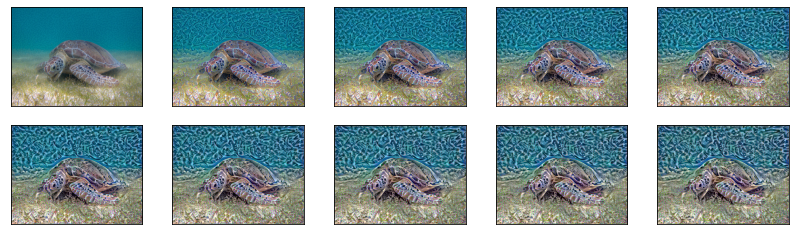

In [19]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=100)

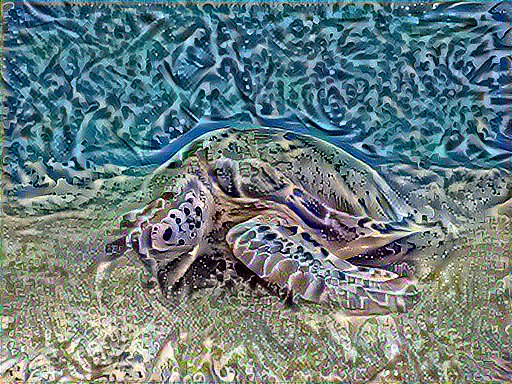

In [20]:
Image.fromarray(best)

## Визуализация выходного изображения
Делаем депроцессинг выходное изображения, чтобы удалить примененную к нему обработку.

In [21]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path) 
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

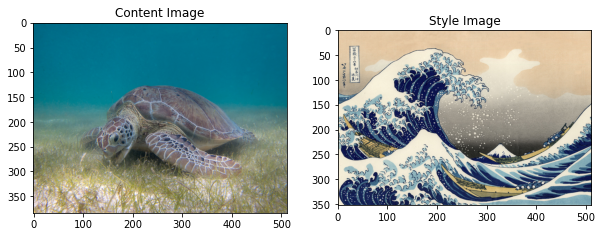

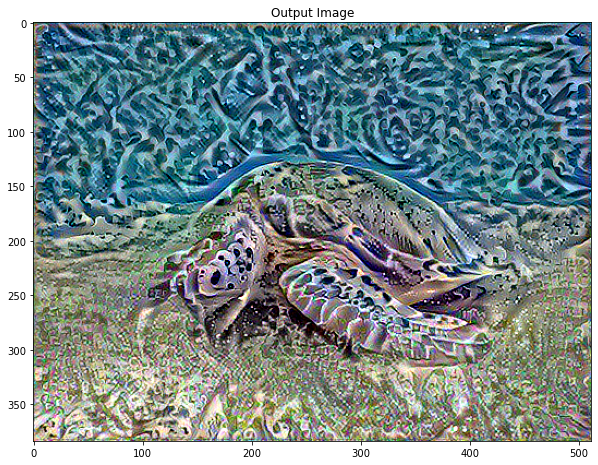

In [22]:
show_results(best, content_path, style_path)

## Попробуем на других изображениях

Изображение Тюбингена 

Photo By: Andreas Praefcke [GFDL (http://www.gnu.org/copyleft/fdl.html) or CC BY 3.0  (https://creativecommons.org/licenses/by/3.0)], from Wikimedia Commons

### Звездная ночь + Тюбинген

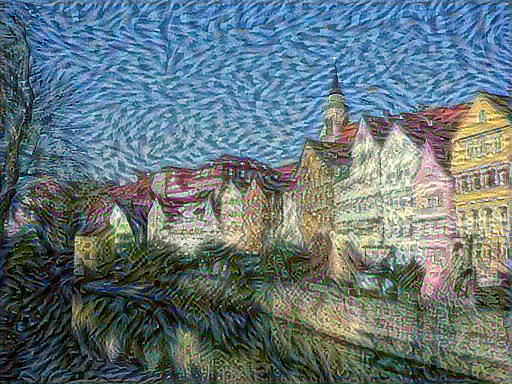

Iteration: 34
Total loss: 8.6626e+06, style loss: 6.4732e+06, content loss: 2.1894e+06, time: 77.6065s


In [ ]:
best_starry_night, best_loss = run_style_transfer('./images/Tuebingen_Neckarfront.jpg',
                                                  './images/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

In [ ]:
show_results(best_starry_night, './images/Tuebingen_Neckarfront.jpg',
             './images/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

### Столпы творения + Тюбинген

In [ ]:
best_poc_tubingen, best_loss = run_style_transfer('./images/Tuebingen_Neckarfront.jpg', 
                                                  './images/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

In [ ]:
show_results(best_poc_tubingen, 
             './images/Tuebingen_Neckarfront.jpg',
             './images/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

### «Композиция VII» Кандинского + Тюбинген

In [ ]:
best_kandinsky_tubingen, best_loss = run_style_transfer('./images/Tuebingen_Neckarfront.jpg', 
                                                  './images/Vassily_Kandinsky,_1913_-_Composition_7.jpg')

In [ ]:
show_results(best_kandinsky_tubingen, 
             './images/Tuebingen_Neckarfront.jpg',
             './images/Vassily_Kandinsky,_1913_-_Composition_7.jpg')

### Столпы творения + Морская черепаха

In [ ]:
best_poc_turtle, best_loss = run_style_transfer('./images/Green_Sea_Turtle_grazing_seagrass.jpg', 
                                                  './images/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

In [ ]:
show_results(best_poc_turtle, 
             './images/Green_Sea_Turtle_grazing_seagrass.jpg',
             './images/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

## Ключевые выводы

### Что мы рассмотрели:

* Мы построили несколько различных функций потерь и использовали обратное распространение для преобразования нашего входного изображения, чтобы минимизировать эти потери.
   * Для этого нам пришлось загрузить **предварительно обученную модель** и использовать ее изученные карты признаков для описания содержимого и стилевого представления наших изображений.
     * Наши основные функции потерь заключались в основном в вычислении расстояния в терминах этих различных представлений.
* Мы реализовали это с помощью специальной модели
   * Мы создали нашу пользовательскую модель с помощью функционального API.
   * Мы напрямую манипулировали тензорами, что упрощает отладку и работу с тензорами.
* Мы итеративно обновляли наше изображение, применяя наши правила обновления оптимизаторов с помощью **tf.gradient**. Оптимизатор минимизировал данную потерю по отношению к нашему входному изображению.


**[Изображение Тюбингена](https://commons.wikimedia.org/wiki/File:Tuebingen_Neckarfront.jpg)** 
Photo By: Andreas Praefcke [GFDL (http://www.gnu.org/copyleft/fdl.html) or CC BY 3.0  (https://creativecommons.org/licenses/by/3.0)], from Wikimedia Commons

**[Изображение морской черепахи](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)**
By P.Lindgren [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Commons

